[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EleonoraAiello/AIM23-24/blob/main/ConvolutionalNeuralNetwork.ipynb)

In [ ]:
!gdown https://drive.google.com/uc?id=1L9-81RzrSwFznmTmdlUJSvMwozpRWNNV
!gdown https://drive.google.com/uc?id=12dBU32tOHl23Ib6WTKOuGkrlTniDTAz8

Downloading...
From (original): https://drive.google.com/uc?id=1L9-81RzrSwFznmTmdlUJSvMwozpRWNNV
From (redirected): https://drive.google.com/uc?id=1L9-81RzrSwFznmTmdlUJSvMwozpRWNNV&confirm=t&uuid=53b57cbe-4743-4ad6-963a-3c8d6b2f6373
To: /content/Medical-MNIST-Classification-master.zip
100% 121M/121M [00:04<00:00, 27.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=12dBU32tOHl23Ib6WTKOuGkrlTniDTAz8
From (redirected): https://drive.google.com/uc?id=12dBU32tOHl23Ib6WTKOuGkrlTniDTAz8&confirm=t&uuid=c65bced8-a6fd-46d7-94a7-3b0ac657e17c
To: /content/Medical.zip
100% 115M/115M [00:05<00:00, 22.0MB/s]


In [ ]:
!unzip Medical-MNIST-Classification-master
!unzip Medical

Streaming output truncated to the last 5000 lines.
  inflating: Medical/Medical_test/AbdomenCT/004088.jpeg  
  inflating: __MACOSX/Medical/Medical_test/AbdomenCT/._004088.jpeg  
  inflating: Medical/Medical_test/AbdomenCT/001265.jpeg  
  inflating: __MACOSX/Medical/Medical_test/AbdomenCT/._001265.jpeg  
  inflating: Medical/Medical_test/AbdomenCT/004964.jpeg  
  inflating: __MACOSX/Medical/Medical_test/AbdomenCT/._004964.jpeg  
  inflating: Medical/Medical_test/AbdomenCT/003521.jpeg  
  inflating: __MACOSX/Medical/Medical_test/AbdomenCT/._003521.jpeg  
  inflating: Medical/Medical_test/AbdomenCT/006689.jpeg  
  inflating: __MACOSX/Medical/Medical_test/AbdomenCT/._006689.jpeg  
  inflating: Medical/Medical_test/AbdomenCT/009069.jpeg  
  inflating: __MACOSX/Medical/Medical_test/AbdomenCT/._009069.jpeg  
  inflating: Medical/Medical_test/AbdomenCT/002849.jpeg  
  inflating: __MACOSX/Medical/Medical_test/AbdomenCT/._002849.jpeg  
  inflating: Medical/Medical_test/AbdomenCT/000177.jpeg  
  

In [ ]:
from sklearn import preprocessing, decomposition, model_selection
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import graphviz
from graphviz import Source
from IPython.display import SVG
import pandas as pd
import numpy as np
import scipy
import random, datetime, os, shutil, math

from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import plot_model

from PIL import Image


In [ ]:
%matplotlib inline
plt.style.use('bmh')
plt.rcParams.update({'font.size': 14,
                     'xtick.labelsize' : 14,
                     'ytick.labelsize' : 14,
                     'figure.figsize' : [12,8],
                     })

## Data import

AbdomenCT : 10000
BreastMRI : 8954
Hand : 10000
ChestCT : 10000
CXR : 10000
HeadCT : 10000


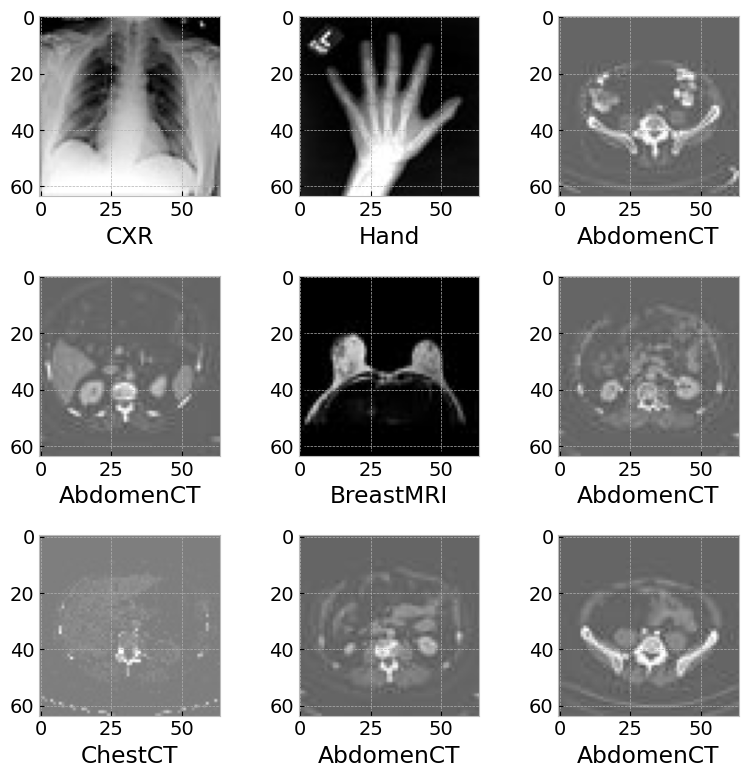

In [ ]:
dataDir = 'Medical-MNIST-Classification-master/resized'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames)

numClass_cnn=0
# Number of types = number of subdirectories
imageFilesList=[]
imageClass=[]
for i in range(numClass):
    g=classNames[i]
    if not g.startswith('.'):
        classNamesFolder=os.listdir(os.path.join(dataDir,classNames[i]))
        numClassFolder = len(classNamesFolder)
        numClass_cnn=numClass_cnn+1
        print(classNames[i],":",numClassFolder)
        for x in range(numClassFolder):
            f=classNamesFolder[x]
            if not f.startswith('.'):
                a=os.path.join(dataDir,classNames[i],classNamesFolder[x])
                imageFilesList.append(a)
                imageClass.extend([i])
                #imageClass.append(i)

numTotal = len(imageFilesList)
plt.subplots(3,3,figsize=(8,8))
for i,k in enumerate(np.random.randint(numTotal, size=9)):  # Take a random sample of 9 images and
    im = Image.open(imageFilesList[k])                      #      plot and label them
    arr = np.array(im)
    plt.subplot(3,3,i+1)

    t=imageFilesList[k]
    pathlist=t.split(os.sep)
    plt.xlabel(pathlist[-2])
    plt.imshow(arr,cmap='gray',vmin=0,vmax=255)
plt.tight_layout()
plt.show()


# Split the dataset into training, validation and test sets

In [ ]:
test_dir = "Medical/Medical_test"
train_dir = "Medical/Medical_train"


image_size = (32, 32, 3)
datagen=ImageDataGenerator(rescale = 1./255,
                           shear_range=0.2,
                           zoom_range=0.2,
                           horizontal_flip=True,
                           validation_split=0.2
                           )

training_set=datagen.flow_from_directory(train_dir,
                                         target_size=image_size[:2],
                                         batch_size=32,
                                         class_mode='categorical',
                                         shuffle=False,
                                         subset='training'
                                         #color_mode='rgb'
                                         )

validation_set = datagen.flow_from_directory(train_dir,
                                         target_size=image_size[:2],
                                         batch_size=32,
                                         class_mode='categorical',
                                         shuffle=False,
                                         subset='validation')


testing_set=datagen.flow_from_directory(test_dir,
                                           target_size=image_size[:2],
                                           batch_size=32,
                                           class_mode='categorical',
                                           shuffle=False
                                           )



Found 33765 images belonging to 6 classes.
Found 8440 images belonging to 6 classes.
Found 16754 images belonging to 6 classes.


# Convolutional Neural Network (CNN)

In [ ]:
def cnn(image_size, num_classes):
    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return classifier

neuralnetwork_cnn = cnn(image_size, numClass_cnn)
neuralnetwork_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        4864      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 6)                

# Training settings

In [ ]:
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=7)

# Training the CNN

In [ ]:
history = neuralnetwork_cnn.fit(training_set, epochs=5,validation_data=validation_set,callbacks=[es])

Epoch 1/5
1056/1056 [==============================] - 220s 208ms/step - loss: 0.2850 - acc: 0.9076 - val_loss: 0.0641 - val_acc: 0.9836
Epoch 2/5
1056/1056 [==============================] - 210s 199ms/step - loss: 0.0438 - acc: 0.9882 - val_loss: 0.0268 - val_acc: 0.9925
Epoch 3/5
1056/1056 [==============================] - 204s 193ms/step - loss: 0.0817 - acc: 0.9814 - val_loss: 0.0364 - val_acc: 0.9903
Epoch 4/5
1056/1056 [==============================] - 208s 197ms/step - loss: 0.0165 - acc: 0.9962 - val_loss: 0.0229 - val_acc: 0.9945
Epoch 5/5
1056/1056 [==============================] - 206s 195ms/step - loss: 0.0894 - acc: 0.9842 - val_loss: 0.0293 - val_acc: 0.9921


# Training metrics

([<matplotlib.axis.XTick at 0x7dee891c9e40>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5')])

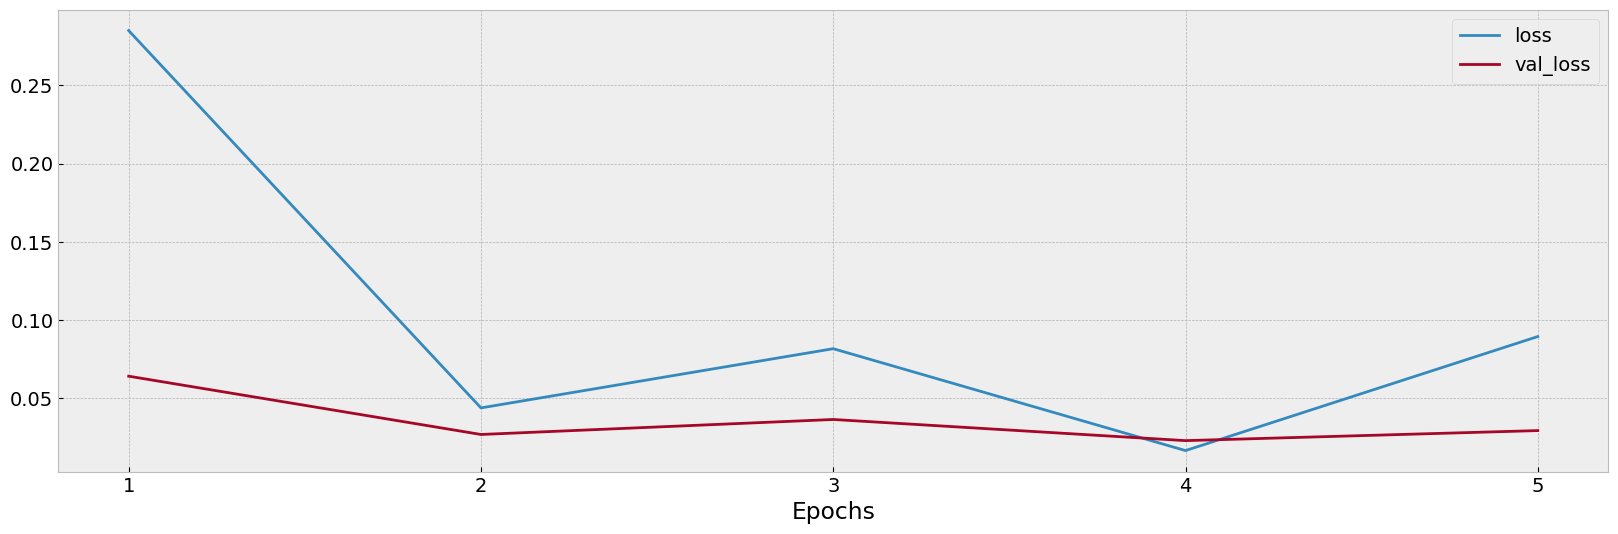

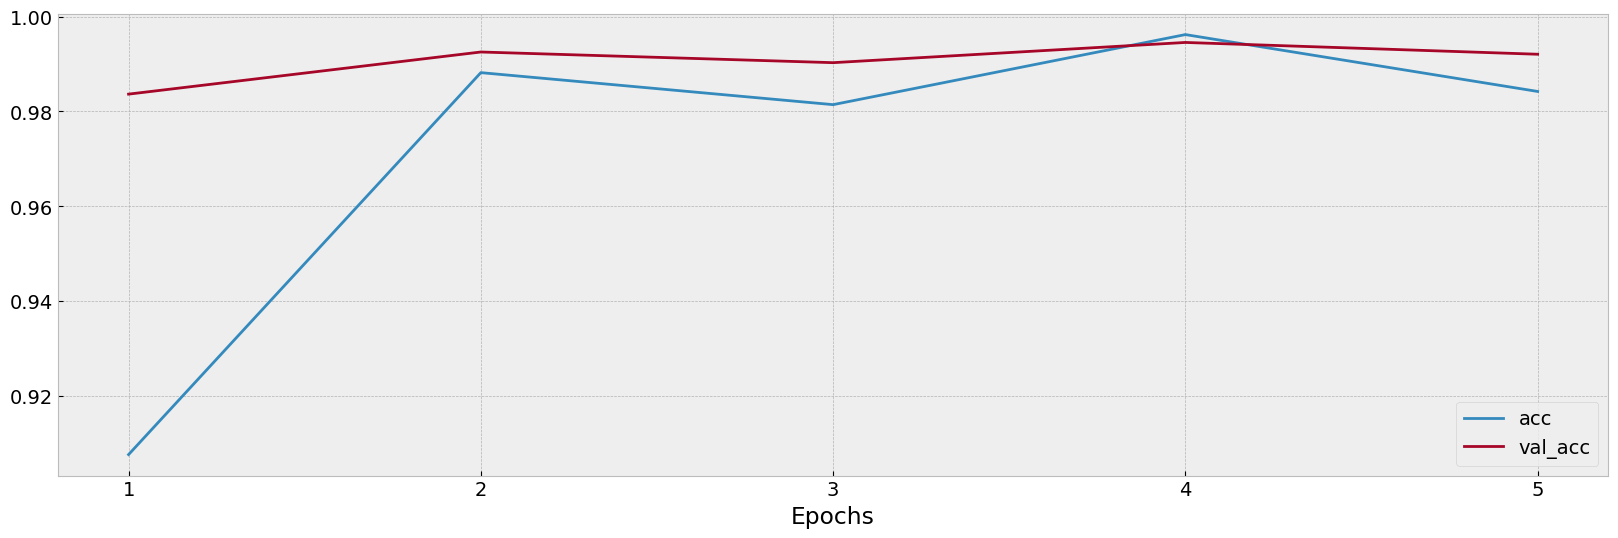

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).iloc[:, [0,2]].plot(ax=ax)
plt.xlabel('Epochs')
plt.xticks([0, 1, 2, 3, 4], [ 1, 2, 3, 4,5])

fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).iloc[:, [1,3]].plot(ax=ax)
plt.xlabel('Epochs')
plt.xticks([0, 1, 2, 3, 4], [ 1, 2, 3, 4,5])


# Confusion Matrix

524/524 [==============================] - 45s 86ms/step


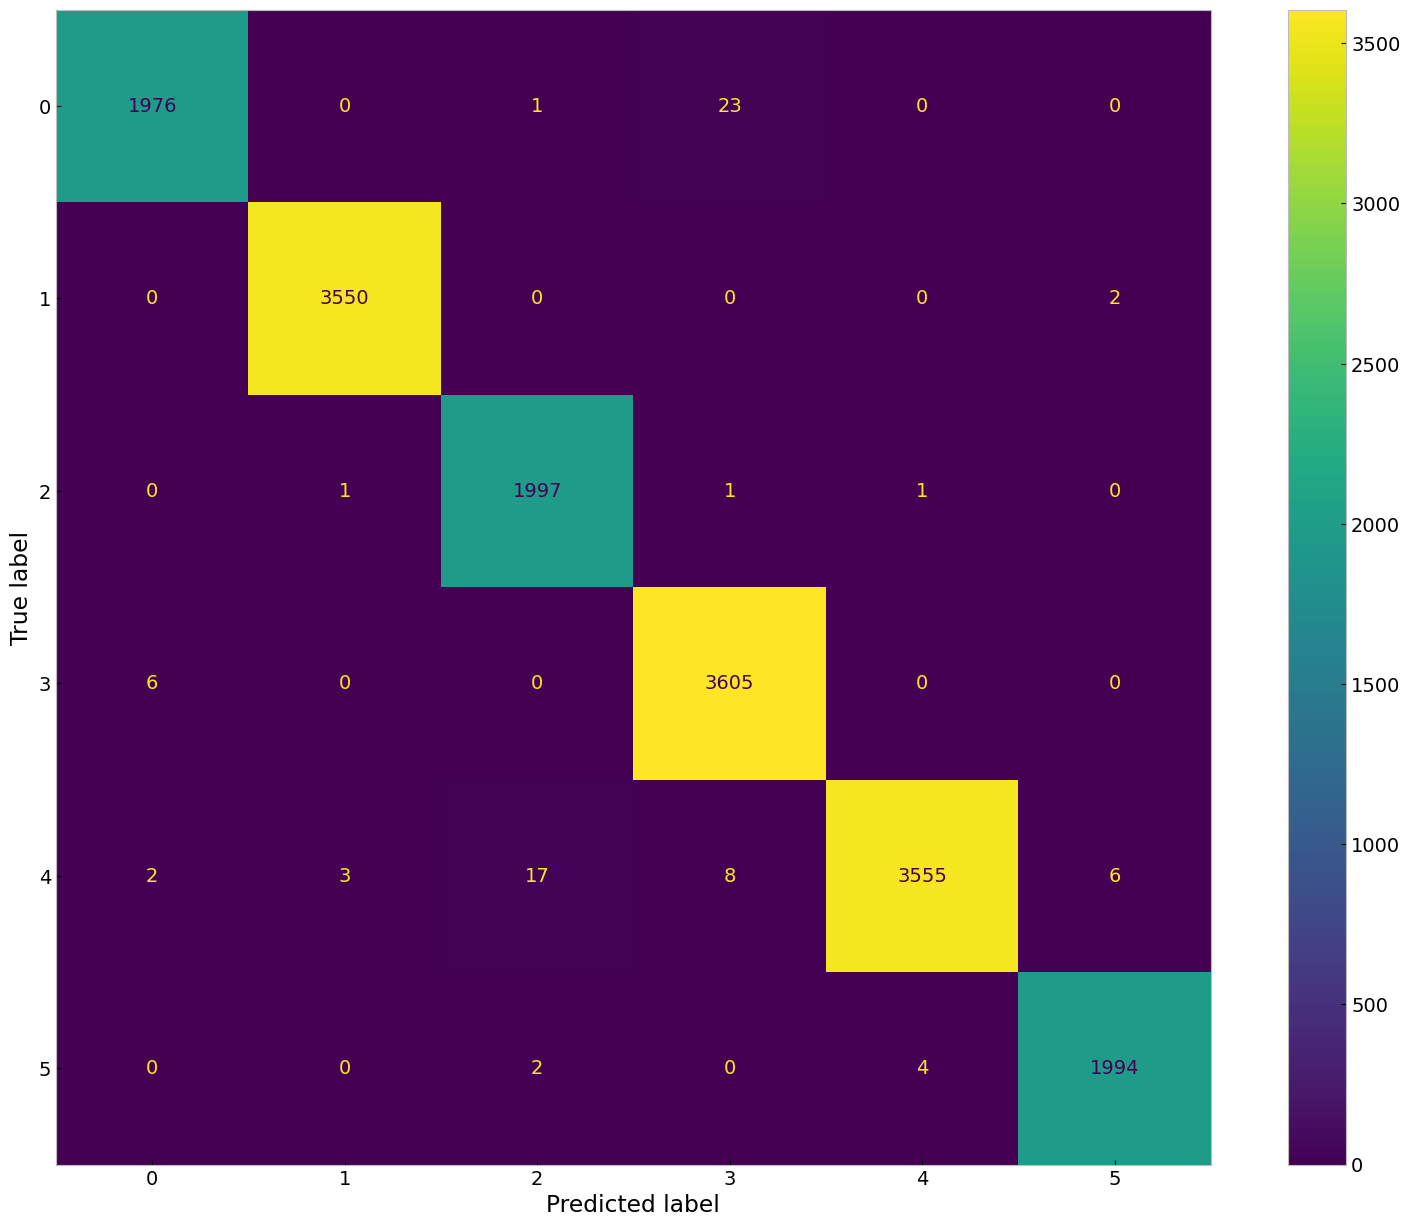

In [ ]:
pred=neuralnetwork_cnn.predict(testing_set)
predicted_class_indices=np.argmax(pred,axis=1)
cm=confusion_matrix(testing_set.labels,predicted_class_indices)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig,ax = plt.subplots(figsize=[20,15])
disp.plot(ax=ax)
plt.grid(False)
